## Problem Set 6

### Joseph Denby

In [3]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

/Users/jgdenby/Library/Python/3.6/lib/python/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
biden = pd.read_csv('../../../ProblemSets/PS6/biden.csv')

In [5]:
biden.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


(a) Split the data into a training set (70%) and a test set (30%). Be sure to set your seed prior to this part of your code to guarantee reproducibility of results. Use recursive binary splitting to fit a decision tree to the training data, with `biden` as the response variable and the other variables as predictors. Plot the tree and interpret the results. What is the test MSE?

In [6]:
y = biden['biden'].values
X = biden[['female', 'age', 'educ', 'dem', 'rep']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [7]:
biden_tree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=3)
biden_tree.fit(X_train, y_train)


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [8]:
y_pred = biden_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 406.67204914577894


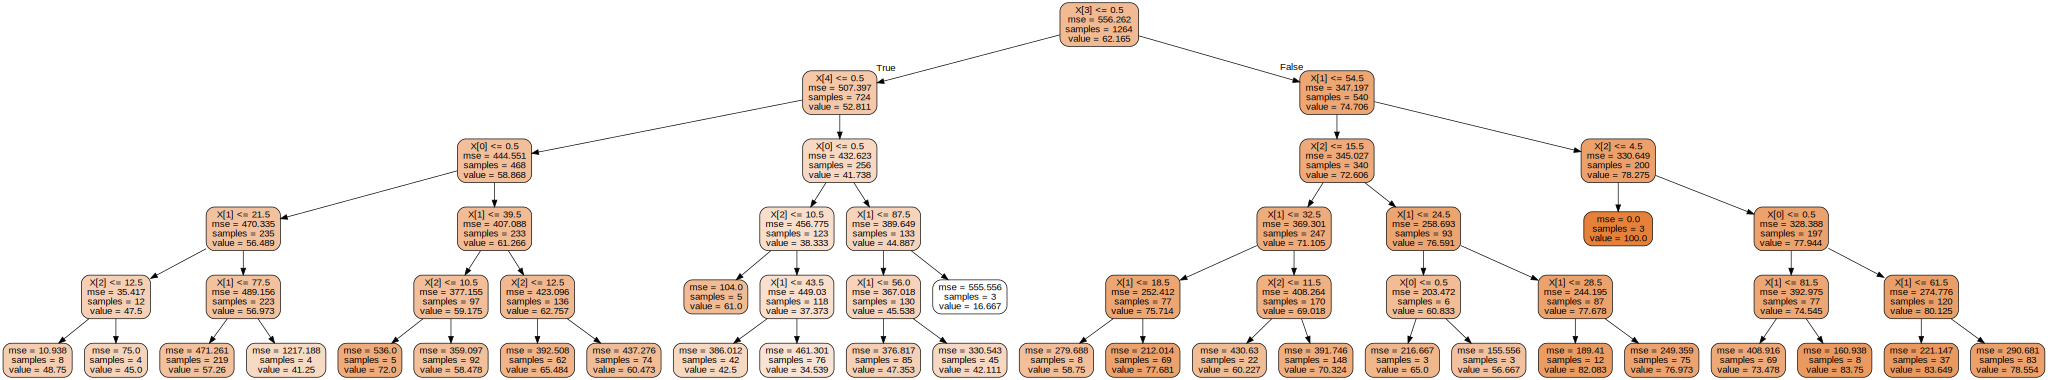

In [10]:
from sklearn.tree import export_graphviz
import graphviz

biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

`X[0] = female`, `X[1] = age`, `X[2] = educ`, `X[3]= dem`, `X[4] = rep`

The first node indicates a split between Democrats and non-Democrats, where Democrats like Biden more (unsurprisingly). If one is a Democrat, the next split is at the age of 54.5, where older people tend to like Biden more. Of those older people, women like Biden more, particularly those under the age 61.5.

Within non-Democrats, the next split occurs within the Republican dimension, with Republicans liking Biden less than non-Republicans. Within Republicans, women tend to like Biden more by a small margin, except for men with fewer than 10.5 years of education. Within people who are neither Republicans nor Democrats, women again tend to like Biden more, especially women over the age of 39.5. However, women younger than 39.5 with fewer than 10.5 years of education have the highest average sentiment of this entire non-Democrat cohort.


(b) Leave the control options for `tree()` at their default values. Now fit another tree to the training data with the following control options: `tree(control = tree.control(nobs = # number of rows in the training set, mindev = 0))` Use cross-validation to determine the optimal level of tree complexity, plot the optimal tree, and interpret the results. Does pruning the tree improve the test MSE?

In [17]:
biden_tree2 = DecisionTreeRegressor(min_samples_leaf=.5)
biden_tree2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=0.5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [18]:
y_pred2 = biden_tree2.predict(X_test)
MSE2 = mean_squared_error(y_test, y_pred2)
print('MSE=', MSE2)

MSE= 535.9626922067962


(c) Use the bagging approach to estimate a tree to create a model for predicting `biden`. What test MSE do you obtain? Obtain variable importance measures and interpret the results.

In [16]:
from sklearn.ensemble import BaggingRegressor

In [37]:
biden_tree3 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=15)
biden_tree3.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=15, verbose=0, warm_start=False)

In [20]:
biden_tree3.score(X, y)
y_pred3 = biden_tree3.oob_prediction_
MSE3 = mean_squared_error(y, y_pred3)
print('MSE=', MSE3)

MSE= 406.0005583949261


In [41]:
importances = np.mean([
    tree.feature_importances_ for tree in biden_tree3.estimators_
], axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

features = ['female', 'age', 'dem', 'rep', 'educ']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))

Feature ranking:
1 .  female :  0.4429127039606069
2 .  age :  0.20057625971613363
3 .  dem :  0.19032354439169072
4 .  rep :  0.10602822551257896
5 .  educ :  0.06015926641898977


Based on the bagging approach to model estimation, `female` appears to be the most important variable with which to explain variance in the `biden` dataset. After that, `age` and the political affiliation variables (`dem` & `rep`) are the next important variables.

(d) Use the random forest approach to estimate a tree to create a model for predicting `biden`. Do this for $m=1,m=2$,and $m=3$ (the number of variables). What test MSE do you obtain in each case? Obtain variable importance measures and interpret the results. Describe the effect of $m$, the number of variables considered at each split, on the error rate obtained.

In [26]:
from sklearn.ensemble import RandomForestRegressor

biden_tree4 = RandomForestRegressor(max_features = 1, n_estimators=53,  bootstrap=True,
                                  oob_score=True, random_state=15)
biden_tree4.fit(X, y)

biden_tree4.score(X, y)
y_pred4 = biden_tree4.oob_prediction_
MSE4 = mean_squared_error(y, y_pred4)
print('For m = 1, MSE=', MSE4)

For m = 1, MSE= 532.8750579722736


In [27]:
biden_tree5 = RandomForestRegressor(max_features = 2, n_estimators=53,  bootstrap=True,
                                  oob_score=True, random_state=15)
biden_tree5.fit(X, y)

biden_tree5.score(X, y)
y_pred5 = biden_tree5.oob_prediction_
MSE5 = mean_squared_error(y, y_pred5)
print('For m = 2, MSE=', MSE5)

For m = 2, MSE= 538.192542935064


In [28]:
biden_tree6 = RandomForestRegressor(max_features = 3, n_estimators=53,  bootstrap=True,
                                  oob_score=True, random_state=15)
biden_tree6.fit(X, y)

biden_tree6.score(X, y)
y_pred6 = biden_tree6.oob_prediction_
MSE6 = mean_squared_error(y, y_pred6)
print('For m = 3, MSE=', MSE6)

For m = 3, MSE= 535.7619627008756


Curious that $m=1$ produces the smallest MSE in this model's case. I would've expected that including more variables in the model would make it more accurate – perhaps the model's MSE would trend downwards with more features.

In [33]:
importances

array([0.0273708 , 0.48465204, 0.16508946, 0.19916532, 0.12372238])

In [31]:
importances = biden_tree6.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_tree6.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

features = ['female', 'age', 'dem', 'rep', 'educ']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))

Feature ranking:
1 .  female :  0.4846520363670528
2 .  age :  0.19916532223909172
3 .  dem :  0.16508946236227023
4 .  rep :  0.12372237934495427
5 .  educ :  0.027370799686630812


Interesting! `female` seems to be the most important variable for this model. Of particular interest is the fact that `dem` and `rep` are both of relatively low importance.